In [12]:
graphics_toolkit("gnuplot"); % use if "plot" does not work

## Finite element method (FEM) in 2d
### Anisotropic material + convection + reaction
Solve the following 2d diffusion boundary value problem using linear finite elements.

In [64]:
%% 2d boundary value problem:
%   -div(K(x)*grad(u(x))) + k0(x)u(x) + k1(x)*diff(u)/dx1 + k2(x)*diff(u)/dx2 = f(x) inside of the domain
%   u(x)=U(x) at GammaD
%   K(x)*(du/dn)(x)=g(x) at GammaN

% parameters of anisotropic diffusion coefficient:
alpha=pi/8; % axis
D=diag([1 2]); % coefficients

% parameters of source:
Uhat = 5;
k0_const = 10;
k0 = @(x)0*x(:,1)+k0_const;
f_const = 0;
f_modif_const = f_const+k0_const*Uhat;

% other parameters:
k1 = @(x)0*x(:,1)+10;
k2 = @(x)0*x(:,1)+10;
f_modif = @(x)0*x(:,1)+f_modif_const;

Consider rectangular domain $(0,L_1)\times(0,L_2)$ and its regular triangulation, i.e. prepare input matrices NODE, ELEM. Also AREAS and CENTERS (area and center of gravity for each triangle) may be useful.

In [65]:
%% example: preparation of a simple network
%  triangulation of a rectangular domain (0,L1)x(0,L2)
nx=30; ny=30;
L1=1; L2=1;
[coords1,coords2]=meshgrid(linspace(0,L1,nx),linspace(0,L2,ny)); % meshgrid
coords1=coords1(:); coords2=coords2(:);
NODE=[coords1 coords2];
n_NODE=size(NODE,1);
ELEM=rectangle_triangulation(nx,ny);
n_ELEM=size(ELEM,1);
AREAS=polyarea(coords1(ELEM),coords2(ELEM),2);
CENTERS=[mean(coords1(ELEM),2),mean(coords2(ELEM),2)];

Preparation of boundary conditions and material inputs:

In [66]:
%% boundary conditions inputs
DBOUNDARY=((coords1==0)|(coords1==1)|(coords2==0)|(coords2==1));
DVALUE=zeros(sum(DBOUNDARY),1); % values of U(x) in boundary nodes
NBOUNDARY=[];    
NVALUE=ones(size(NBOUNDARY,1),1); % values of g(x) on boundary edges!
FREENODE=true(n_NODE,1); FREENODE(DBOUNDARY)=false;

%% other input data
U=[cos(alpha) sin(-alpha); sin(alpha) cos(-alpha)];
K=U*D*U';
MATERIALS=ones(n_ELEM,1)*reshape(U*D*U',1,4); % anisotropic diffusion coefficient
MATERIALS0=k0(CENTERS); % coefficient of reactive term
MATERIALS1=k1(CENTERS); % coefficient of convection in x1 direction
MATERIALS2=k2(CENTERS); % coefficient of convection in x2 direction
SOURCE=f_modif(CENTERS); % source term

Construct FEM matrix and right hand side vector using local matrices and vectors:

In [67]:
%% construction of global matrix and rhs
A=zeros(n_NODE);
b=zeros(n_NODE,1);
for i=1:n_ELEM

    % local "stiffness" matrix
    x=NODE(ELEM(i,:),:);
    B_=[x(2,2)-x(3,2) x(3,2)-x(1,2) x(1,2)-x(2,2);
        x(3,1)-x(2,1) x(1,1)-x(3,1) x(2,1)-x(1,1)];
    A_local=(B_')*reshape(MATERIALS(i,:),2,2)*B_/4/AREAS(i);
    
    % local "mass" matrix
    J=abs(2*AREAS(i));
    M_local=J*MATERIALS0(i)*[2 1 1; 1 2 1; 1 1 2]/24;
    
    % local matrix for convection in x1 direction
    DF=[x(2,1)-x(1,1) x(3,1)-x(1,1);
    x(2,2)-x(1,2) x(3,2)-x(1,2)];
    tmp=[-1 1 0; -1 0 1]'*inv(DF);
    P1_local=J*MATERIALS1(i)*tmp(:,1)*[1 1 1]/6;
    
    % local matrix for convection in x2 direction
    P2_local=J*MATERIALS2(i)*tmp(:,2)*[1 1 1]/6;
    
    % add local matrices to the global matrix
    A(ELEM(i,:),ELEM(i,:))=A(ELEM(i,:),ELEM(i,:))+A_local+M_local+P1_local+P2_local;
    
    % add local rhs
    b_local=SOURCE(i)*AREAS(i)/3;
    b(ELEM(i,:))=b(ELEM(i,:))+b_local;
end

Eliminate unknowns corresponding to Dirichlet nodes, modify the r. h. s. vector according to Neumann boundary conditions, and solve the resulting linear system:

In [68]:
%% modifications due to boundary conditions
u=zeros(n_NODE,1);
u(DBOUNDARY)=DVALUE;
b=b-A*u;
for i=1:length(NVALUE)
    x=NODE(NBOUNDARY(i,:),:);
    b(NBOUNDARY(i,:))=b(NBOUNDARY(i,:))+1/2*norm(x(2,:)-x(1,:))*NVALUE(i);
end

Plot solution:

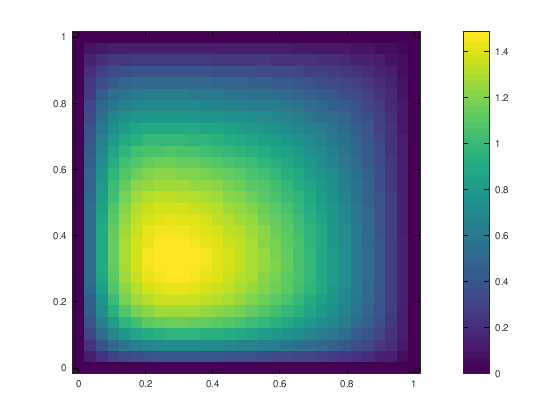

In [69]:
%% solution of the resulting linear system and visualization
u(FREENODE)=A(FREENODE,FREENODE)\b(FREENODE);
figure; 
#trimesh(ELEM,coords1,coords2,u);
imagesc([0,L1],[0,L2],reshape(u,nx,ny));
set(gca,'YDir','normal')
colorbar()